# DP-SurfaceDetection - Training run


In [1]:
# import system packages
import os
import json
import glob
import numpy as np
import random as rand
import librosa
import librosa.display
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# import pytorch stuff
import torch
import torch.nn as nn
from torch.utils import data
import torchvision.transforms as T
from torch.utils.data import *
from torchvision import models

# import own python files
%load_ext autoreload
%autoreload 2
from train import *



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [3]:
# FCN with Resnet-101 backbone

def decode_segmap(image, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def segment(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    print (om.shape)
    print (np.unique(om))
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.axis('off'); plt.show()


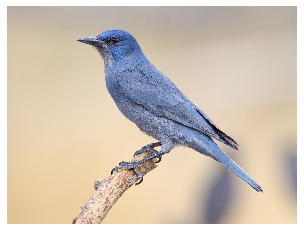

(640, 853)
[0 3]


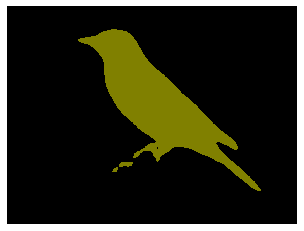

In [4]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
segment(fcn, '../bird.jpg', dev=device)

In [5]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [ ]:
segment(dlab, '../horse.jpg', dev=device)

In [5]:
import cv2

def decode_segmap_unsat(image, source, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]


    rgb = np.stack([r, g, b], axis=2)

    # Load the foreground input image 
    foreground = cv2.imread(source)

    # Change the color of foreground image to RGB 
    # and resize image to match shape of R-band in RGB output map  
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

    # Create a background image by copying foreground and converting into grayscale
    background = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

    # convert single channel grayscale image to 3-channel grayscale image
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2RGB)

    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)

    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (7,7),0)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)  

    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)  

    # Add the masked foreground and background
    outImage = cv2.add(foreground, background)

    # Return a normalized output image for display
    return outImage/255

def segment_unsat(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
        
        
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

    rgb = decode_segmap_unsat(om, path)

    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    plt.imshow(rgb); plt.axis('off'); plt.show()
    
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

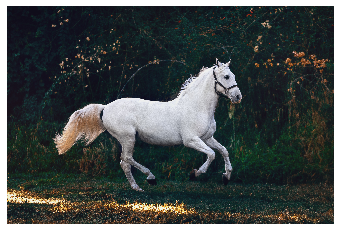

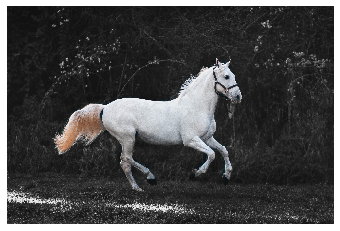

In [6]:
segment_unsat(dlab, '../horse.jpg', show_orig=True, dev=device)


In [21]:
def decode_segmap_blur(image, source, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]


    rgb = np.stack([r, g, b], axis=2)

    # Load the foreground input image 
    foreground = cv2.imread(source)

    # Change the color of foreground image to RGB 
    # and resize image to match shape of R-band in RGB output map  
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

    # Create a Gaussian blur of kernel size 7 for the background image
    blurredImage = cv2.GaussianBlur(foreground, (7,7), 0)

    # Convert uint8 to float
    foreground = foreground.astype(float)
    blurredImage = blurredImage.astype(float)

    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (7,7),0)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)  

    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, blurredImage)  

    # Add the masked foreground and background
    outImage = cv2.add(foreground, background)

    # Return a normalized output image for display
    return outImage/255

def segment_blur(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)

    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

    rgb = decode_segmap_blur(om, path)

    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    plt.imshow(rgb); plt.axis('off'); plt.show()

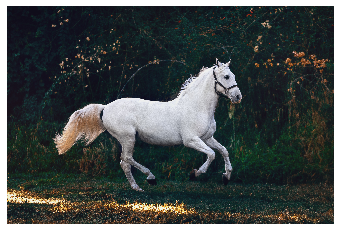

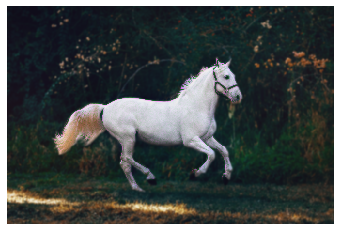

In [22]:
segment_blur(dlab, '../horse.jpg', show_orig=True, dev=device)